In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")


In [3]:
train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)


In [4]:
def get_cnn_encoder(input_shape, filters, kernel_sizes, bottleneck_size,
                    dnn_layer_sizes=None, strides=None, paddings="same", activation='relu'):
    if strides is None:
        strides = [(1, 1) for _ in range(len(filters))]

    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(filters[0], kernel_size=kernel_sizes[0], strides=strides[0], padding=paddings)(input_layer)

    for i in range(1, len(filters)):
        x = layers.Conv2D(filters[i], kernel_size=kernel_sizes[i], strides=strides[i], padding=paddings)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

    x = layers.Flatten(name='flatten')(x)

    if dnn_layer_sizes is not None:
        for n_nodes in dnn_layer_sizes:
            x = layers.Dense(n_nodes, activation=activation)(x)

    x = layers.Dense(bottleneck_size, activation=activation)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x)

    flatten_idx = 1
    for i, layer in enumerate(model.layers):
        if layer.name == 'flatten':
            flatten_idx = i
    pre_flatten_idx = flatten_idx - 1

    pre_flatten_dim = model.layers[pre_flatten_idx].output_shape
    n_flatten_nodes = model.layers[flatten_idx].output_shape

    return model, pre_flatten_dim, n_flatten_nodes

In [5]:
def get_cnn_decoder(bottleneck_size, pre_flatten_dim, n_flatten_nodes, filters, kernel_sizes, 
                    dnn_layer_sizes=None, strides=None, paddings="same", activation='relu'):
    if pre_flatten_dim[-1] != filters[0]:
        raise ValueError("filter sizes do not match encoder dimensions")
   
    if strides is None:
        strides = [(1, 1) for _ in range(len(filters))]

    input_layer = layers.Input(shape=(bottleneck_size))

    if dnn_layer_sizes is not None:
        x = layers.Dense(dnn_layer_sizes[0], activation=activation)(input_layer)
        for n_nodes in dnn_layer_sizes[1:]:
            x = layers.Dense(n_nodes, activation=activation)(x)
        x = layers.Dense(n_flatten_nodes)(x)
    else:
        x = layers.Dense(n_flatten_nodes)(input_layer)
    
    x = layers.Reshape(pre_flatten_dim)(x)

    new_filters = filters[1:] + [1]
    for i in range(len(new_filters) - 1):
        x = layers.Conv2DTranspose(new_filters[i], kernel_size=kernel_sizes[i], strides=strides[i], padding=paddings)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(new_filters[-1], kernel_size=kernel_sizes[-1], strides=strides[-1], padding=paddings, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x)

    return model

In [6]:
bottleneck_size = 10

filters = [32, 64, 64, 64]
kernel_sizes = [3, 3, 3, 3]
strides = [1, 2, 2, 1]
layer_sizes = None  # [128, 10]

filters_r = list(reversed(filters))
kernel_sizes_r = list(reversed(kernel_sizes))
strides = [1, 2, 2, 1]
layer_sizes_r = None  # list(reversed(layer_sizes))

In [7]:
enc, pre_flatten_dim, n_flatten_nodes = get_cnn_encoder(
    input_shape=(28, 28, 1), 
    bottleneck_size=bottleneck_size,
    filters=filters, 
    kernel_sizes=kernel_sizes, 
    dnn_layer_sizes=layer_sizes
)

In [8]:
dec = get_cnn_decoder(
    bottleneck_size=bottleneck_size, 
    pre_flatten_dim=pre_flatten_dim[1:], 
    n_flatten_nodes=n_flatten_nodes[1],
    filters=filters_r,
    kernel_sizes=kernel_sizes_r,
    dnn_layer_sizes=layer_sizes_r
)

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [10]:
@tf.function
def train_step(images):
 
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
       
        latent = enc(images, training=True)
        generated_images = dec(latent, training=True)
        loss = loss_object(images, generated_images)
         
    gradients_of_enc = encoder.gradient(loss, enc.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, dec.trainable_variables)
     
    optimizer.apply_gradients(zip(gradients_of_enc, enc.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, dec.trainable_variables))

    train_loss(loss)

@tf.function
def test_step(images):
    predictions = dec(enc(images, training=False), training=False)
    t_loss = loss_object(images, predictions)

    test_loss(t_loss)

In [11]:
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss.reset_states()
    test_loss.reset_states()

    start = time.time()
    for images, labels in train_ds:
        train_step(images)
    print(f'epoch: {epoch + 1} | train loss: {train_loss.result()}')

    for test_data, test_labels in test_ds:
        test_step(images)
    print(f'epoch: {epoch + 1} | test loss: {test_loss.result()}\n')

epoch: 1 | train loss: 0.0
epoch: 1 | test loss: 0.0

epoch: 2 | train loss: 0.0
epoch: 2 | test loss: 0.0



KeyboardInterrupt: 

In [12]:
for image, label in train_ds:
    img = image
    break

img = tf.expand_dims(img[0], axis=0)

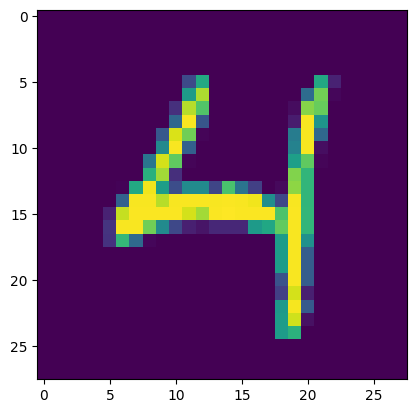

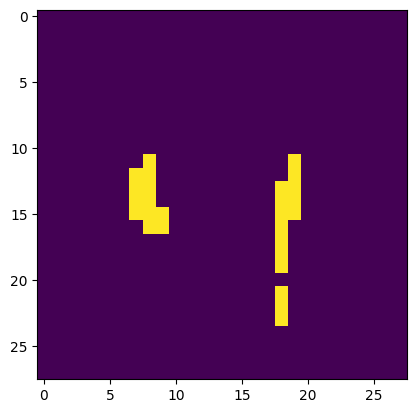

In [13]:
img_data = np.squeeze(img.numpy())
# latent = enc(images[idx])
x_test[0]
gen_img_data = np.squeeze(dec(enc(img, training=False), training=False).numpy())

plt.imshow(img_data)
plt.show()

plt.imshow(gen_img_data)
plt.show()